In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
customers = pd.read_csv('./dacon_data/open/customers.csv')
locations = pd.read_csv('./dacon_data/open/locations.csv')
orders = pd.read_csv('./dacon_data/open/orders.csv')
order_items = pd.read_csv('./dacon_data/open/order_items.csv')
payments = pd.read_csv('./dacon_data/open/payments.csv')
products = pd.read_csv('./dacon_data/open/products.csv')
reviews = pd.read_csv('./dacon_data/open/reviews.csv')
sellers = pd.read_csv('./dacon_data/open/sellers.csv')
temp = pd.merge(reviews,order_items, how='inner',on='Order_id')
temp = pd.merge(temp,orders, how='inner',on='Order_id')
temp = pd.merge(temp,payments, how='inner',on='Order_id')
temp = pd.merge(temp,products, how='inner',on='Product_id')
temp = pd.merge(temp,customers, how='inner',on='Customer_id')
temp = pd.merge(temp,sellers, how='inner',on='Seller_id')
temp = temp.drop(["Review_creation_date","Review_answer_timestamp","Order_status","Payment_sequential","Payment_type","Payment_installments"],axis=1)
# temp = temp.drop(["Product_weight_g","Product_length_cm","Product_height_cm","Customer_zipcode_prefix","Seller_zipcode_prefix"],axis=1)
# temp = temp.drop(["Product_width_cm"],axis=1)

In [510]:
# temp = temp.drop(["Product_width_cm"],axis=1)

In [3]:
temp.shape

(104956, 26)

In [511]:
# temp = temp.drop(["Product_weight_g","Product_length_cm","Product_height_cm"],axis=1)

In [4]:
# locations[locations.Geolocation_zipcode_prefix == 14600]
# location 중복된 우편번호?
# locations.Geolocation_zipcode_prefix.unique().size #19015
# locations.shape #1000163
# locations.Geolocation_zipcode_prefix.value_counts().reset_index()
locations_group_lat=locations.groupby(["Geolocation_zipcode_prefix"])["Geolocation_lat"].mean().reset_index()
locations_group_lng=locations.groupby(["Geolocation_zipcode_prefix"])["Geolocation_lng"].mean().reset_index()

In [5]:
locations_group =  pd.merge(locations_group_lat, locations_group_lng, how = 'inner', on="Geolocation_zipcode_prefix")

In [6]:
# 6030
locations_group_lat[locations_group_lat.Geolocation_zipcode_prefix==6030]

,Geolocation_zipcode_prefix,Geolocation_lat
3069,6030,-23.557079


In [7]:
temp = pd.merge(temp, locations_group, left_on = 'Customer_zipcode_prefix', right_on = 'Geolocation_zipcode_prefix', how = 'inner')

In [8]:
temp = temp.rename(columns={'Geolocation_lat':'Customer_lat',"Geolocation_lng" : "Customer_lng" })

In [9]:
# locations_group_lat=locations.groupby(["Geolocation_zipcode_prefix"])["Geolocation_lat"].mean().reset_index()
# locations_group_lng=locations.groupby(["Geolocation_zipcode_prefix"])["Geolocation_lng"].mean().reset_index()
# locations_group =  pd.merge(locations_group_lat, locations_group_lng, how = 'inner', on="Geolocation_zipcode_prefix")
temp = pd.merge(temp, locations_group, left_on = 'Seller_zipcode_prefix', right_on = 'Geolocation_zipcode_prefix', how = 'inner')
temp = temp.rename(columns={'Geolocation_lat':'Seller_lat',"Geolocation_lng" : "Seller_lng" })

In [10]:
temp.drop(["Geolocation_zipcode_prefix_x","Geolocation_zipcode_prefix_y","Customer_zipcode_prefix", "Seller_zipcode_prefix"], axis=1,inplace=True)

In [11]:
temp["Distance"] = ((temp["Customer_lat"] - temp["Seller_lat"])**2 + (temp["Customer_lng"] - temp["Seller_lng"])**2) **(1/2)

In [520]:
384 / temp.shape[0]

0.0036768930253935424

In [521]:
# temp[temp.Distance==0] # 21개

In [441]:
# temp[temp.Freight_value==0] #384 0.3퍼라서 무시가능

In [442]:
# temp[temp.Distance==0]["Freight_value"] #이동거리가 없는데 왜 요금을 받을까? 어떻게 처리할까=>무시하자

In [443]:
# temp["Distance"].describe()

In [12]:
temp_drop = temp[temp.Distance!=0]

In [13]:
temp.shape[0]- temp_drop.shape[0]

21

In [14]:
temp_drop.shape[0]

104415

In [15]:
temp_drop = temp_drop[temp_drop.Freight_value!=0]

In [16]:
temp_drop.shape[0]

104031

In [17]:
temp_drop.Distance.describe()

count    104031.000000
mean          5.548139
std           5.328310
min           0.000488
25%           1.829185
50%           4.093069
75%           7.382681
max          48.219429
Name: Distance, dtype: float64

In [18]:
temp_drop.Freight_value.describe()

count    104031.000000
mean         19.847675
std          15.363738
min           0.010000
25%          13.080000
50%          16.180000
75%          20.990000
max         409.680000
Name: Freight_value, dtype: float64

In [19]:
temp_drop["Pay_distance"] = temp_drop["Freight_value"] / temp_drop["Distance"]
#5km 에 3000원이면 1km 600원인건지 

In [20]:
temp_drop.Pay_distance.describe()

count    104031.000000
mean         17.129127
std          90.265786
min           0.001198
25%           2.583370
50%           4.279616
75%           9.260592
max       15943.628976
Name: Pay_distance, dtype: float64

In [21]:
data_pay_distance = np.array(temp_drop.Pay_distance)

In [22]:
Q1 = np.percentile(data_pay_distance, 25)
Q3 = np.percentile(data_pay_distance, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = data_pay_distance[(data_pay_distance < lower_bound) | (data_pay_distance > upper_bound)]

In [23]:
outliers.shape #이상치의 개수가 15112 개다

(15112,)

In [24]:
temp_drop.shape[0] #이상치에 포함이 안되는것은 104031개다

104031

In [25]:
temp_drop.shape[0] / outliers.shape[0]  # 7퍼를 무시할수있을까

6.883999470619376

In [26]:
temp_drop["Outliers"] = (temp_drop['Pay_distance'] < lower_bound) | (temp_drop['Pay_distance'] > upper_bound)

In [459]:
# temp_drop[temp_drop["Outliers"]==True] #개수확인 15112개 맞다

In [27]:
temp_drop["earn"] = temp_drop['Price']* temp_drop['Order_item_id'] #화물가치빼기

In [28]:
all_earn_sum = temp_drop["earn"].sum()
all_earn_sum  # 11665320.41  운임요금과 거리가 0인걸 제거해도 큰차이가 나지않는다
# 11762681.18

14105158.81

In [29]:
temp_drop_Outliers = temp_drop.groupby(["Outliers"])["earn"].sum()

In [30]:
temp_drop_Outliers #True => 1928918.77

Outliers
False    11864735.12
True      2240423.69
Name: earn, dtype: float64

In [31]:
temp_drop_Outliers[1] / all_earn_sum #16퍼를 차지하기에 무시못한다 이상치를 고려해줘야한다.

0.15883718291860904

In [465]:
# temp_drop.iloc[0]

In [466]:
# temp_drop['Product_weight_g'].head(10)

In [32]:
temp_drop['Product_weight_g'] = temp_drop['Product_weight_g'].replace('Unknown', np.nan).fillna(0).astype(float)

In [33]:
temp_drop[['Freight_value', 'Distance',"Product_weight_g"]].corr()  #0.392 정도 운임요금과 거리 0.616무게와 더 연관성이 있다 
#거의 40퍼와 60퍼
# 거리는 줄일수있지만 무게는 줄일수없다. 
# 무게는 같은 품목일경우 근처로 정해주자

,Freight_value,Distance,Product_weight_g
Freight_value,1.000000,0.391769,0.616224
Distance,0.391769,1.000000,-0.008208
Product_weight_g,0.616224,-0.008208,1.000000


In [34]:
# Product_id : 제품 고유 ID
# Product_category_name : 카테고리 이름
# Product_weight_g : 제품 무게(g)
# Product_length_cm : 제품 길이(cm)
# Product_height_cm : 제품 높이(cm)
# Product_width_cm : 제품 너비(cm)

In [35]:
temp_drop['Product_id'].describe() #총 29190개 

count            104031
unique            29190
top       PRODUCT_08596
freq                497
Name: Product_id, dtype: object

In [36]:
product_id_counts = temp_drop['Product_id'].value_counts()

In [37]:
product_id_counts.describe()

count    29190.000000
mean         3.563926
std         10.550529
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        497.000000
Name: count, dtype: float64

In [38]:
product_id_counts_over_10 = product_id_counts[product_id_counts >= 10]

In [474]:
# for i in range(1,100,5):
#     print(np.percentile(product_id_counts, i))
# 백분위 계산

In [39]:
product_id_counts_over_10.shape

(1864,)

In [40]:
product_id_df = product_id_counts.reset_index()

In [41]:
product_id_df_over_10 = product_id_df[product_id_df["count"] >=10]

In [42]:
product_id_list = product_id_df_over_10.Product_id #10개가 넘는 품목의 리스트를 저장

In [43]:
temp_drop_10 = temp_drop[temp_drop["Product_id"].isin(product_id_list)] #10개가 넘는 품목의 리스트를 저장하는 데이터프레임

In [44]:
temp_drop_10.earn.sum() #총 합 4530190.869999999 나중에 비교해보기위해서

5616745.29

In [481]:
#같은 물건을 파는 사람들을 더 거리가 가까운 지점으로 옮기는거야
# PRODUCT_08596 
# test_temp = temp_drop_10[temp_drop_10.Product_id=="PRODUCT_08596"]

In [482]:
# test_temp.Distance.describe()

In [483]:
# temp_drop_10.iloc[0]

In [45]:
min_values = temp_drop_10.groupby('Product_id')['Freight_value'].min().reset_index() #각 product_id에 따른 운임요금의 최소값

In [46]:
min_values.head(1)

,Product_id,Freight_value
0,PRODUCT_00006,14.08


In [47]:
temp_drop_10_1 = temp_drop_10.copy()

In [48]:
temp_drop_10_merged = pd.merge(temp_drop_10_1,min_values, how='inner',on='Product_id')

In [488]:
# temp_drop_10_merged.iloc[1] #Freight_value_x  Freight_value_y

In [49]:
temp_drop_10_merged.head(1) #기존의 earn을 덮자

,Review_id,Order_id,Review_score,Order_item_id,Product_id,Seller_id,Price,Freight_value_x,Customer_id,Order_purchase_timestamp,...,Seller_state,Customer_lat,Customer_lng,Seller_lat,Seller_lng,Distance,Pay_distance,Outliers,earn,Freight_value_y
0,REVIEW_00001,ORDER_80140,5,1,PRODUCT_18124,SELLER_0262,79.79,8.3,CUSTOMER_81808,2019-02-28 12:25:19,...,SP,-22.785779,-47.312537,-23.246681,-45.886909,1.498281,5.539682,False,79.79,8.3


In [53]:
temp_drop_10_merged["earn"] = temp_drop['Price']* temp_drop['Order_item_id']

In [54]:
temp_drop_10_merged.earn.sum() #수정후 바뀐값

6404974.82

In [55]:
temp_drop_10_merged.earn.sum() - temp_drop_10.earn.sum() 

788229.5300000003

In [493]:
# 센터를 늘리거나, 중간 거점
# 운임 비용이 비싸서 손해가 발생한 거라면, 
# 배송 거리가 멀어서 운임 비용이 비싸진 거라면, 가까운 지역에 구매를 유도하자

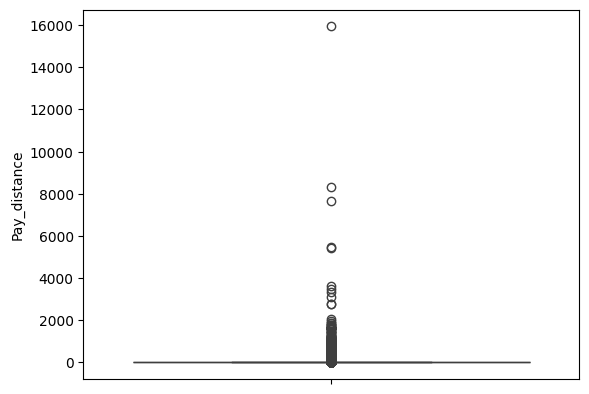

In [494]:
import seaborn as sns
sns.boxplot(temp_drop.Pay_distance)
plt.show()